In [1]:
## import packages used in this session 
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as m
import pprint as pp
import scipy.stats as st
from plotnine import *
# Silence warnings 
import warnings
warnings.filterwarnings("ignore")
##set seed
np.random.seed(1234)

In [2]:
## import data
turnout=pd.read_csv("turnout.csv")

In [3]:
## filter and keep relevant columns
turnout=turnout.filter(["age", "educate", "income", "vote", "white"])

__Begin by splitting the data into a training and test dataset.__

In [4]:
## split data into training(1600 observations) and test(400 observations)
train = turnout.sample(frac=.8).reset_index(drop=True)
test = turnout.drop(train.index).reset_index(drop=True)

##print shape to confirm split
print(train.shape[0])
print(test.shape[0])

1600
400


__Then calculate class probabilities: $Pr(class)$__

In [5]:
## calculate class probabilities;subset data by class(i.e, voted vs did not vote)
vote_1=train.query("vote==1")
vote_0=train.query("vote==0")

# calculate probability for each class subsetted above
pr_vote_1=vote_1.shape[0]/train.shape[0]
pr_vote_0=vote_0.shape[0]/train.shape[0]

##display probabilities
print(pr_vote_1)
print(pr_vote_0)

0.7425
0.2575


__Determine conditional means and standard deviations for the contionous predictors (age, educate, income)__

In [6]:
##calculate conditional means and standard deviation for continous predictors (age,educate, income)
cond_msdev = \
{("age",1):{'mean':vote_1.age.mean(),'sd':vote_1.age.std()},
 ("age",0):{'mean':vote_0.age.mean(),'sd':vote_0.age.std()},
 ("educate",1):{'mean':vote_1.educate.mean(),'sd':vote_1.educate.std()},
 ("educate",0):{'mean':vote_0.educate.mean(),'sd':vote_0.educate.std()},
 ("income",1):{'mean':vote_1.income.mean(),'sd':vote_1.income.std()},
 ("income",0):{'mean':vote_0.income.mean(),'sd':vote_0.income.std()}
}

##print conditional means and standard deviation for each continous predictor
pp.pprint(cond_msdev)

{('age', 0): {'mean': 42.601941747572816, 'sd': 19.147825402160812},
 ('age', 1): {'mean': 46.32491582491583, 'sd': 16.924844588853716},
 ('educate', 0): {'mean': 10.62864077669903, 'sd': 3.304381091983527},
 ('educate', 1): {'mean': 12.558922558922559, 'sd': 3.295714127444309},
 ('income', 0): {'mean': 2.7381618932038836, 'sd': 2.2429913729337625},
 ('income', 1): {'mean': 4.229461952861947, 'sd': 2.8482089910676964}}


__Use means and standard deviations to determine prediction for when class (i.e, vote)==1 and for when class==0__

In [7]:
##generate prediction for when class (i.e, vote)==1
age_vote_1=st.norm(cond_msdev[("age",1)]['mean'], cond_msdev[("age",1)]['sd']).pdf(train.age)
educ_vote_1=st.norm(cond_msdev[("educate",1)]['mean'], cond_msdev[("educate",1)]['sd']).pdf(train.educate)
inc_vote_1=st.norm(cond_msdev[("income",1)]['mean'], cond_msdev[("income",1)]['sd']).pdf(train.income)

In [8]:
##generate prediction for when class (i.e, vote)==0
age_vote_0=st.norm(cond_msdev[("age",0)]['mean'], cond_msdev[("age",0)]['sd']).pdf(train.age)
educ_vote_0=st.norm(cond_msdev[("educate",0)]['mean'], cond_msdev[("educate",0)]['sd']).pdf(train.educate)
inc_vote_0=st.norm(cond_msdev[("income",0)]['mean'], cond_msdev[("income",0)]['sd']).pdf(train.income)

__Now determine conditional probability for the binary predictor variable (i.e., white) for when the class==1 and for when class==0__

In [9]:
## calculate conditional probability for binary predictor variable (white)
#given vote==1
white1_vote_1=vote_1.query("white==1").shape[0]/vote_1.shape[0]
white0_vote_1=vote_1.query("white==0").shape[0]/vote_1.shape[0]

##given vote==0
white1_vote_0=vote_0.query("white==1").shape[0]/vote_0.shape[0]
white0_vote_0=vote_0.query("white==0").shape[0]/vote_0.shape[0]

##print probabilities
print(
f"""
Pr(white = 1 |vote = 1): {white1_vote_1}
Pr(white = 0 |vote = 1): {white0_vote_1}
Pr(white = 1 |vote = 0): {white1_vote_0}
Pr(white = 0 |vote = 0): {white0_vote_0}
""")


Pr(white = 1 |vote = 1): 0.8686868686868687
Pr(white = 0 |vote = 1): 0.13131313131313133
Pr(white = 1 |vote = 0): 0.7985436893203883
Pr(white = 0 |vote = 0): 0.20145631067961164



__Store conditional probabilities determined above and the class probability into a dataframe__

In [10]:
## create a dataframe with the conditional probabilities for the continious predictors 
df = pd.DataFrame(data=[age_vote_1, educ_vote_1,inc_vote_1,age_vote_0,educ_vote_0,inc_vote_0]).T

In [11]:
##rename column headers
df.rename(columns={0:'age_vote_1',
                          1:'educ_vote_1',
                          2:'inc_vote_1',3:'age_vote_0', 4:'educ_vote_0',5:'inc_vote_0'}, 
                 inplace=True)
 

In [12]:
## add class probability and the conditional proabilities for the binary variable as columns to the dataframe above
df=df.assign(white1_vote_1=white1_vote_1, white0_vote_1=white0_vote_1, white1_vote_0=white1_vote_0,white0_vote_0=white0_vote_0,pr_vote_1=pr_vote_1, pr_vote_0=pr_vote_0)

__Multiply across columns for when vote==0 and for when vote==1 separately then determine prediction for each observation.__

In [13]:
##create column 'pr_1' which will be the probability of vote==1 given conditional probability of our predictors
df['pr_1']=df.age_vote_1*df.educ_vote_1*df.inc_vote_1*df.white1_vote_1*df.white0_vote_1*df.pr_vote_1

In [14]:
##create column 'pr_0' which will be the probability of vote==0 given conditional probability of our predictors
df['pr_0']=df.age_vote_0*df.educ_vote_0*df.inc_vote_0*df.white1_vote_0*df.white0_vote_0*df.pr_vote_0

In [15]:
##create new dataframe with just the probabilities of voting and not voting for each observation
predic_train=df[['pr_0','pr_1']]

In [16]:
##create a new column which will represent the class prediction for each observation
predic_train.loc[:,'pred'] = np.where(predic_train.loc[:, ('pr_0')]>= predic_train.loc[:, ('pr_1')], 0, 1)

In [17]:
##disply dataframe
predic_train

,pr_0,pr_1,pred
0,7.318136e-07,2.016467e-06,1
1,2.601785e-07,7.331657e-08,0
2,7.966244e-06,8.593187e-06,1
3,1.577312e-06,1.014169e-06,0
4,5.137542e-06,7.502856e-06,1
...,...,...,...
1595,1.090398e-05,1.014329e-05,0
1596,3.467140e-06,2.113825e-06,0
1597,1.791864e-06,1.171918e-06,0
1598,2.898712e-06,6.203744e-06,1


In [18]:
## determine accuracy of predictions 
accuracy_train = sum(train.vote == predic_train.pred)/train.shape[0]
accuracy_train

0.728125

__Now determine predictive accuracy on the test data.__

In [19]:
##generate prediction for when class (i.e, vote)==1
age_vote_1=st.norm(cond_msdev[("age",1)]['mean'], cond_msdev[("age",1)]['sd']).pdf(test.age)
educ_vote_1=st.norm(cond_msdev[("educate",1)]['mean'], cond_msdev[("educate",1)]['sd']).pdf(test.educate)
inc_vote_1=st.norm(cond_msdev[("income",1)]['mean'], cond_msdev[("income",1)]['sd']).pdf(test.income)

In [20]:
##generate prediction for when class (i.e, vote)==0
age_vote_0=st.norm(cond_msdev[("age",0)]['mean'], cond_msdev[("age",0)]['sd']).pdf(test.age)
educ_vote_0=st.norm(cond_msdev[("educate",0)]['mean'], cond_msdev[("educate",0)]['sd']).pdf(test.educate)
inc_vote_0=st.norm(cond_msdev[("income",0)]['mean'], cond_msdev[("income",0)]['sd']).pdf(test.income)

In [21]:
## subset data by class(i.e, voted vs did not vote)
vote_1=test.query("vote==1")
vote_0=test.query("vote==0")

In [22]:
## calculate conditional probability for binary predictor variable (white)
#given vote==1
white1_vote_1=vote_1.query("white==1").shape[0]/vote_1.shape[0]
white0_vote_1=vote_1.query("white==0").shape[0]/vote_1.shape[0]

##given vote==0
white1_vote_0=vote_0.query("white==1").shape[0]/vote_0.shape[0]
white0_vote_0=vote_0.query("white==0").shape[0]/vote_0.shape[0]

In [23]:
## create a dataframe with the conditional probabilities for the continious predictors 
df_test = pd.DataFrame(data=[age_vote_1, educ_vote_1,inc_vote_1,age_vote_0,educ_vote_0,inc_vote_0]).T

In [24]:
##rename column headers
df_test.rename(columns={0:'age_vote_1',
                          1:'educ_vote_1',
                          2:'inc_vote_1',3:'age_vote_0', 4:'educ_vote_0',5:'inc_vote_0'}, 
                 inplace=True)
 

In [25]:
## add class probability and the conditional proabilities for the binary variable as columns to the dataframe above
df_test=df_test.assign(white1_vote_1=white1_vote_1, white0_vote_1=white0_vote_1, 
             white1_vote_0=white1_vote_0,white0_vote_0=white0_vote_0,pr_vote_1=pr_vote_1, pr_vote_0=pr_vote_0)

In [26]:
##create column 'pr_1' which will be the probability of vote==1 given conditional probability of our predictors
df_test['pr_1']=df_test.age_vote_1*df_test.educ_vote_1*df_test.inc_vote_1*df_test.white1_vote_1*df_test.white0_vote_1*df_test.pr_vote_1

In [27]:
##create column 'pr_0' which will be the probability of vote==0 given conditional probability of our predictors
df_test['pr_0']=df_test.age_vote_0*df_test.educ_vote_0*df_test.inc_vote_0*df_test.white1_vote_0*df_test.white0_vote_0*df_test.pr_vote_0

In [28]:
##create new dataframe with just the probabilities of voting and not voting for each observation
predic_test=df_test[['pr_0','pr_1']]

In [29]:
##create a new column which will represent the class prediction for each observation
predic_test.loc[:,'pred'] = np.where(predic_test.loc[:, ('pr_0')]>= predic_test.loc[:, ('pr_1')], 0, 1)

In [30]:
##disply dataframe
predic_test

,pr_0,pr_1,pred
0,3.318772e-06,0.000011,1
1,3.774543e-06,0.000021,1
2,5.556663e-06,0.000008,1
3,1.372659e-05,0.000022,1
4,3.241743e-07,0.000005,1
...,...,...,...
395,3.032273e-06,0.000008,1
396,1.426107e-05,0.000020,1
397,2.974777e-07,0.000007,1
398,9.433320e-06,0.000007,0


In [31]:
## determine predictive accuracy 
accuracy_test = sum(test.vote == predic_test.pred)/test.shape[0]
accuracy_test

0.72

The predictive accuracy on the training data is 72.8% while the predictive accuracy on the test data is 72%. The classifier preformed slightly better on the training data than the test data.

__Use the sklearn.metrics library to calculate the predictive accuracy and the area underneath the ROC curve.__

In [32]:
# Organize data so it plugs into the sklearn API easily 
train_vote = train['vote']
train_x = train[['age','educate','income','white']]
test_vote = test['vote']
test_x = test[['age','educate','income','white']]

In [33]:
# Instantiate the model class
gnb = GaussianNB()
gnb.fit(train_x, train_vote) # Train

# Predict 
y_pred = gnb.predict(test_x)

#determine predictive accuracy 
m.accuracy_score(test_vote,y_pred)

0.7125

In [34]:
##area under ROC curve
m.roc_auc_score(test_vote,y_pred)

0.575595238095238

__Generate a ROC curve plot.__

In [35]:
##First, we need the model to return probabilities not predictions. 
probs = gnb.predict_proba(test_x)
probs =  pd.DataFrame(probs,columns=gnb.classes_)
probs

,0,1
0,0.382004,0.617996
1,0.089185,0.910815
2,0.275975,0.724025
3,0.255162,0.744838
4,0.036055,0.963945
...,...,...
395,0.168330,0.831670
396,0.274707,0.725293
397,0.021379,0.978621
398,0.438499,0.561501


In [36]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_vote, probs[1])

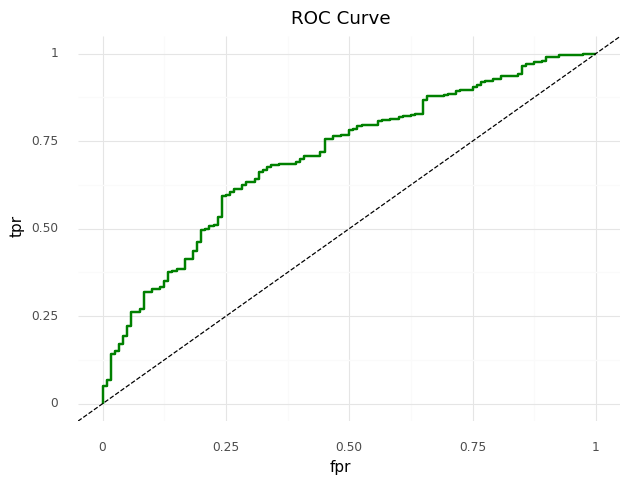

<ggplot: (8764137706487)>

In [37]:
# Plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="green",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve") +
    theme(figure_size=(7,5))
)

Based on the sklearn metrics, the predictive accuracy is approximately 71%. This means that our model will predict whether or not a person voted (given the predictors we have) about 71% of the time. Additionally, the sklearn metrics calculates the AUC to be approximately 0.57--this means this model performs relatively better than a coin flip.